In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [2]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, PMT2_top \
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, skiprows=0,unpack=True)
    return x, PMT1

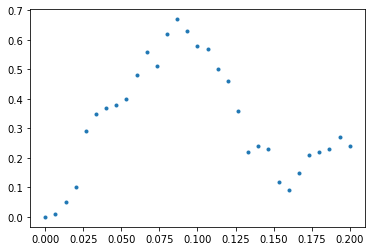

In [3]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_025')
plt.plot(xb, BSB, '.')

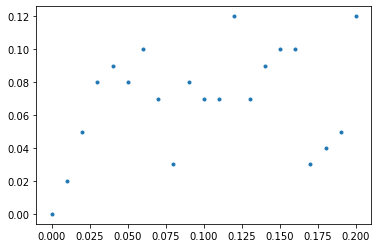

In [4]:
xr, RSB = readFile('RamanTimeScan_CounterProp_RSB_Tilt_025')
plt.plot(xr, RSB, '.')

## Define Hamiltonian

In [7]:
times = xb
nMax = 20

In [8]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

### Test the Hamiltonian

(0, 1)

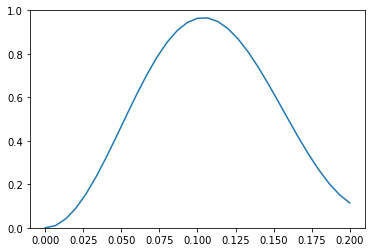

In [10]:
H0 = []
n0 = 0.1
etaOmega = 29
for t in xb:
    H0.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
plt.plot(xb,H0)
plt.ylim([0,1])

## Define heating rate fit

In [52]:
def Heating(x, a):
    return a * x
def heatingFit(xdata, ydata):
    popt, pcov = curve_fit(Heating, xdata, ydata)
    plt.plot(xdata, Heating(xdata, popt), 'b-',
         label='fit: Heating rate=%5.3f q/s' % tuple(popt))
    plt.plot(xdata, ydata, 'r.', label='data')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Motional quanta')
    plt.show()
    print(popt)

## Method 1: Curve fit

In [12]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)
def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

In [13]:
def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    print(popt)
    return Red(xdata, *popt)
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.legend()
    plt.show()
    print(popt)
    return popt

[ 0.05763893 37.33156419]


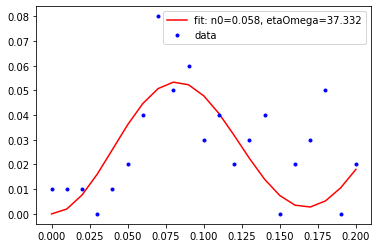

In [86]:
### RSB
xdata = xr
ydata = RSB
guess = np.array([0.1, 30])
RSB_fit = FitRed(xdata, ydata, guess)

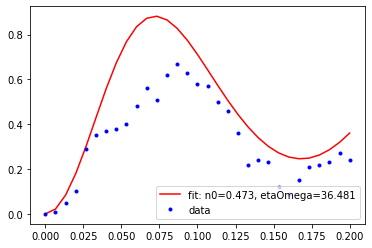

[ 0.47294315 36.48050967]


In [15]:
### BSB
xdata = xb
ydata = BSB
guess = np.array([0.4, 29])
BSB_fit = FitBlue(xdata, ydata, guess)

#### Fit with curve_fit

The loop fitting doesn't work well because it's highly sensitive to the initial guess. We need to change it mannually

## RF = 265

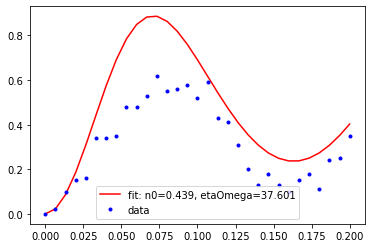

[ 0.43941982 37.60122666]


In [20]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_027')
guess = np.array([1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

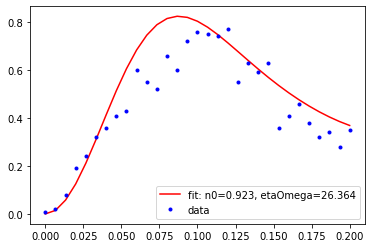

[ 0.92327676 26.36384562]


In [18]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_026')
guess = np.array([0.1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

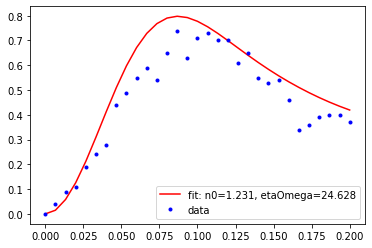

[ 1.23095463 24.62809236]


In [21]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_028')
guess = np.array([1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

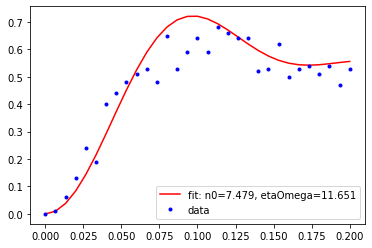

[ 7.4793918  11.65091708]


In [22]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_029')
guess = np.array([1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

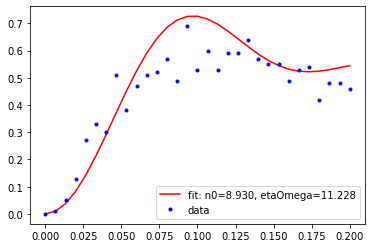

[ 8.92983451 11.22809597]


In [23]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_030')
guess = np.array([1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

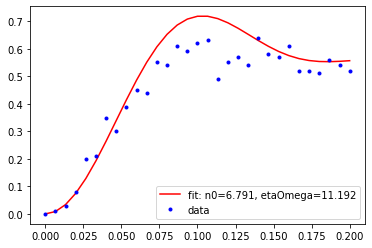

[ 6.79089239 11.19166357]


In [24]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_031')
guess = np.array([1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

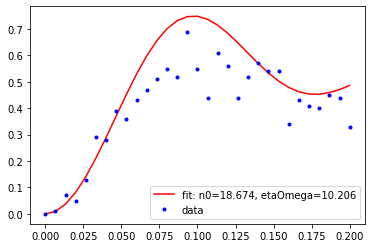

[18.67377847 10.20598733]


In [25]:
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_032')
guess = np.array([1, 40])
BSB_fit = FitBlue(xb, BSB, guess)

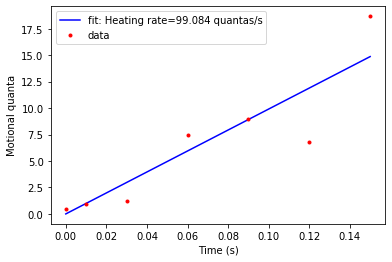

[99.0843523]


In [26]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
n265 = [0.43941982, 0.92327676, 1.23095463, 7.4793918, 8.92983451, 6.79089239, 18.67377847]
heatingFit(T, n265)

## RF = 300

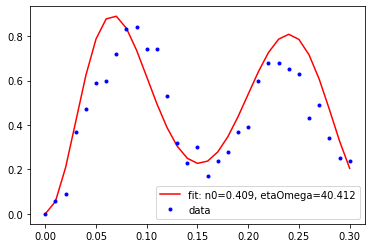

[ 0.40920362 40.41235567]


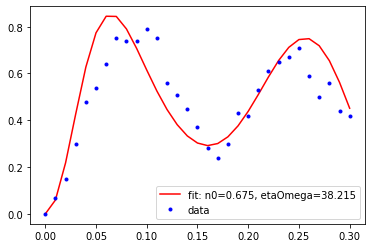

[ 0.67491236 38.21510839]


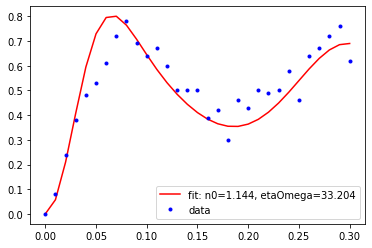

[ 1.1442563  33.20407458]


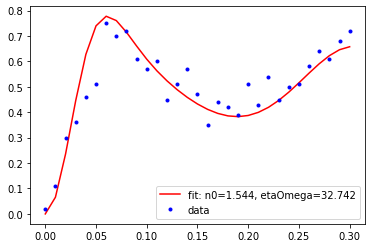

[ 1.54403304 32.74156565]


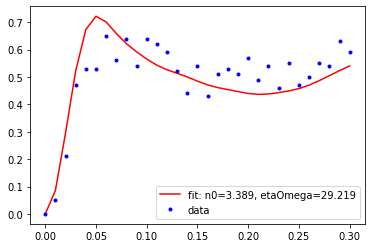

[ 3.38883744 29.21900672]


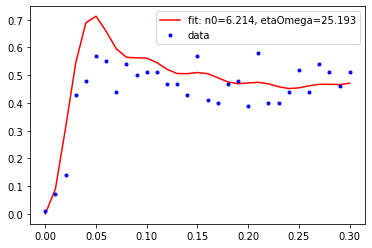

[ 6.21405605 25.193493  ]


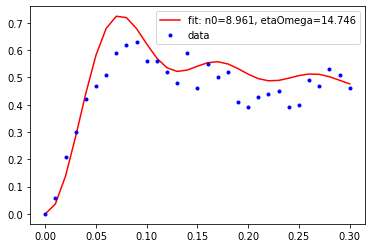

[ 8.96059215 14.74593563]


In [48]:
n300 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_018')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_019')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_020')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_021')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_022')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_023')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_024')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

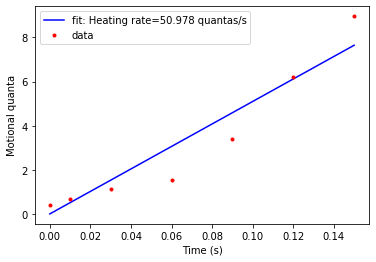

[50.97761517]


In [32]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n300)

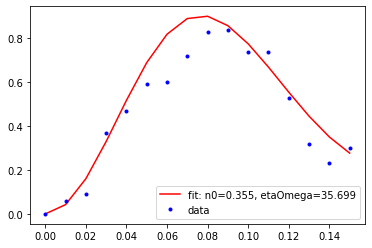

[ 0.35453072 35.69886611]


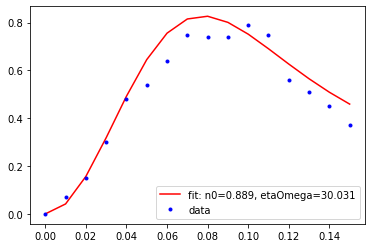

[ 0.88850773 30.03108177]


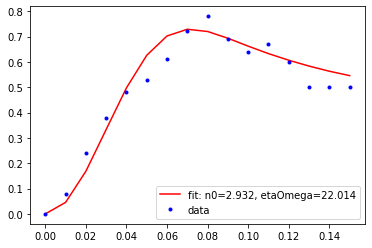

[ 2.93150197 22.01356935]


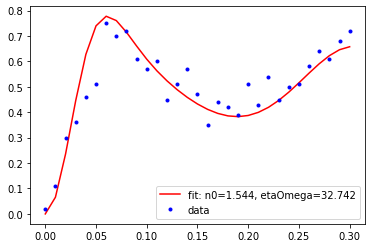

[ 1.54403304 32.74156565]


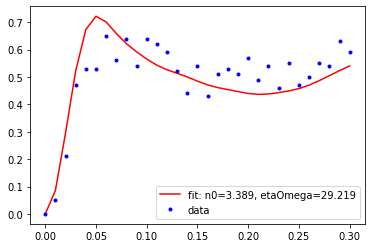

[ 3.38883744 29.21900672]


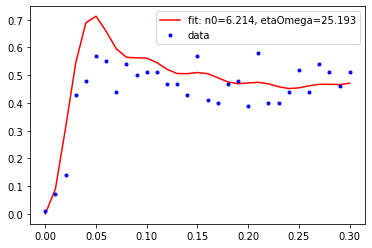

[ 6.21405605 25.193493  ]


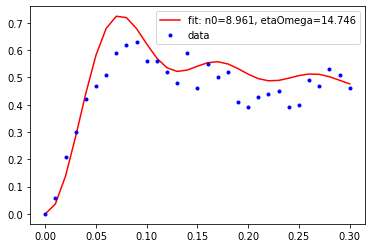

[ 8.96059215 14.74593563]


In [59]:
n300 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_018')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_019')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_020')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_021')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_022')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_023')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_024')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n300.append(BSB_fit[0])

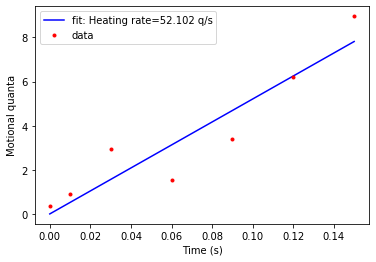

[52.10167411]


In [60]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n300)

## RF = 325

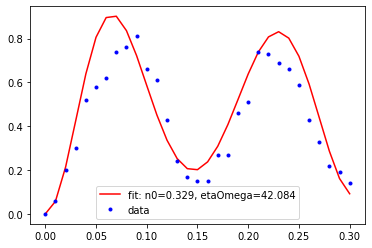

[ 0.32894518 42.0840591 ]


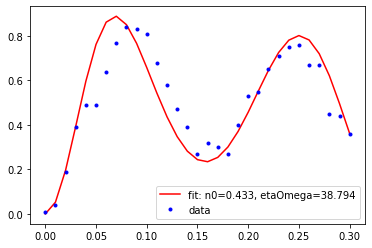

[ 0.43293337 38.7937629 ]


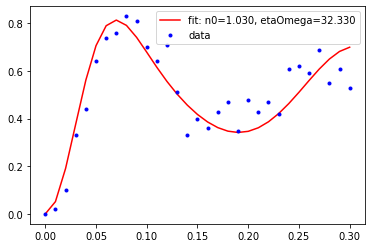

[ 1.02995201 32.32985115]


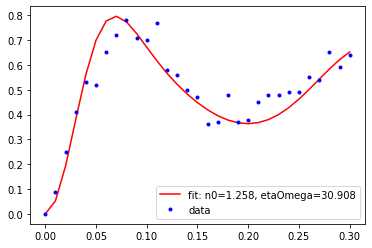

[ 1.25849659 30.90765309]


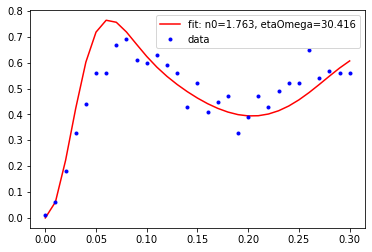

[ 1.76309061 30.41621647]


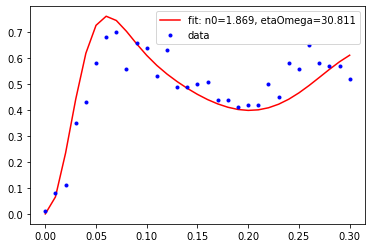

[ 1.86880422 30.81136148]


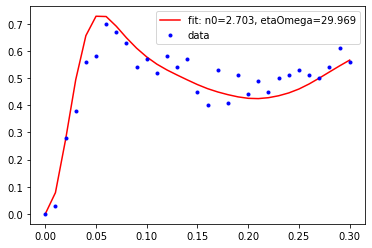

[ 2.70271561 29.96930735]


In [33]:
n325 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_010')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_011')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_012')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_013')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_014')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_015')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_016')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

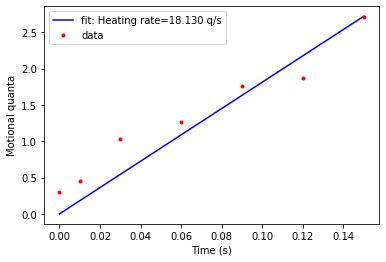

[18.12975992]


In [58]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n325)

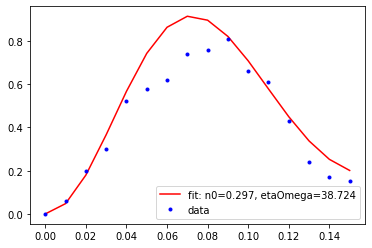

[ 0.29721667 38.7243463 ]


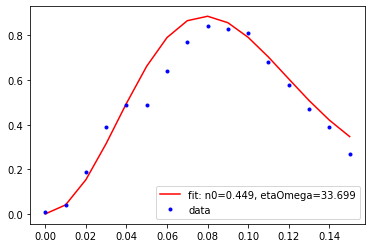

[ 0.44857324 33.69913265]


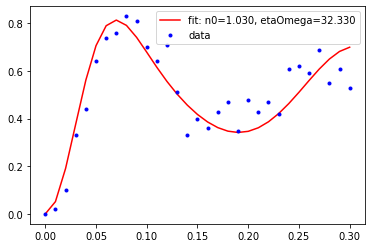

[ 1.02995201 32.32985115]


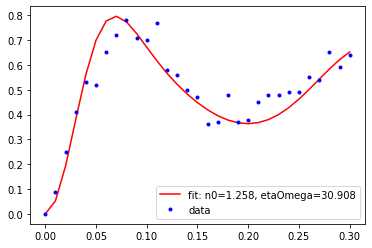

[ 1.25849659 30.90765309]


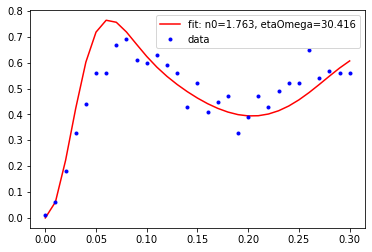

[ 1.76309061 30.41621647]


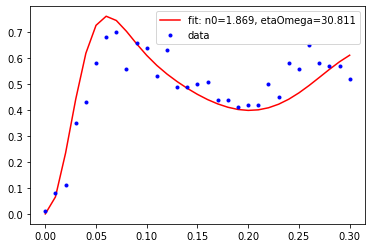

[ 1.86880422 30.81136148]


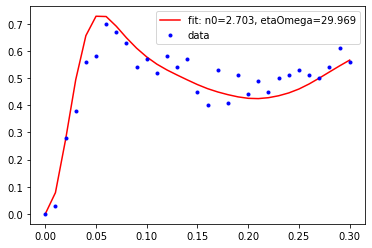

[ 2.70271561 29.96930735]


In [61]:
n325 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_010')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_011')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_012')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_013')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_014')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_015')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_016')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n325.append(BSB_fit[0])

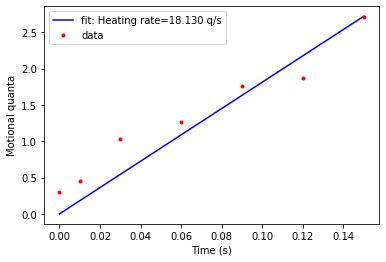

[18.12975992]


In [62]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n325)

## RF = 350

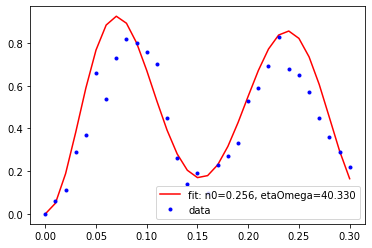

[ 0.25584609 40.32968399]


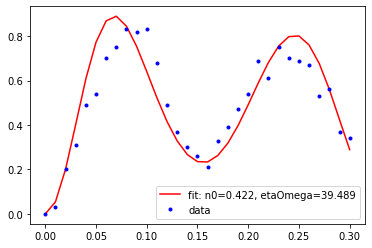

[ 0.42163665 39.48882265]


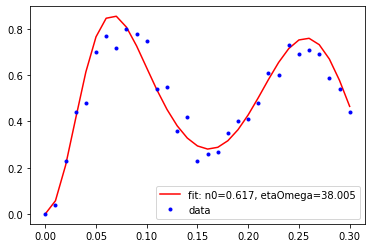

[ 0.61739311 38.00461525]


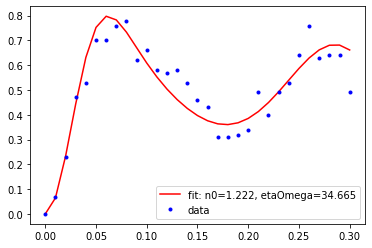

[ 1.22180613 34.6646176 ]


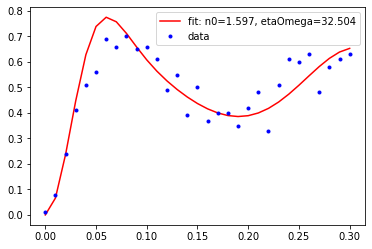

[ 1.59694351 32.50351141]


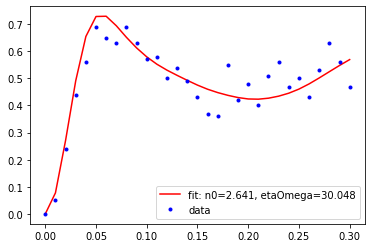

[ 2.64144068 30.04808283]


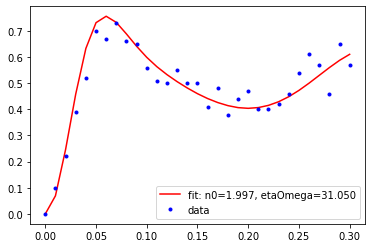

[ 1.99717208 31.05029157]


In [35]:
n350 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_002')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_003')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_004')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_005')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_006')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_007')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_008')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

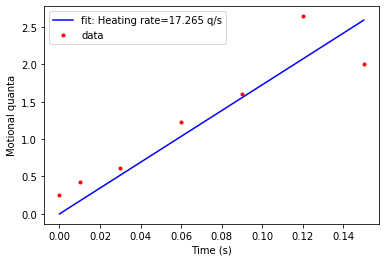

[17.26451891]


In [56]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n350)

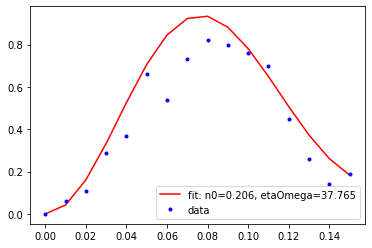

[ 0.2056609  37.76453676]


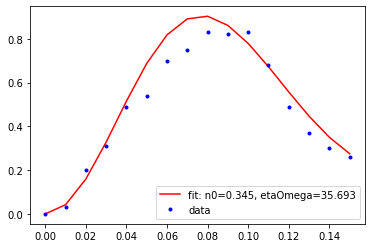

[ 0.34489979 35.69286517]


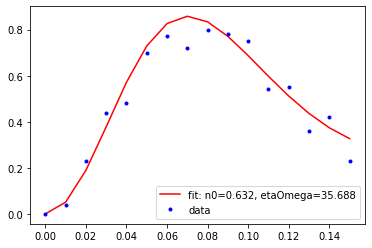

[ 0.63178321 35.68780771]


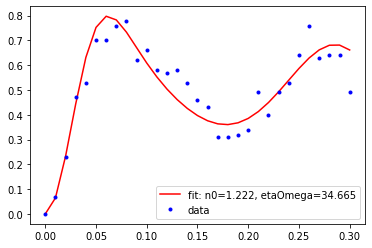

[ 1.22180613 34.6646176 ]


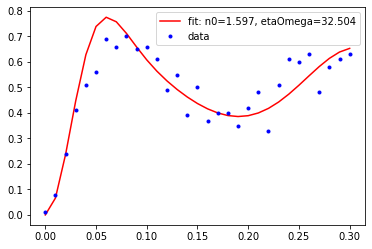

[ 1.59694351 32.50351141]


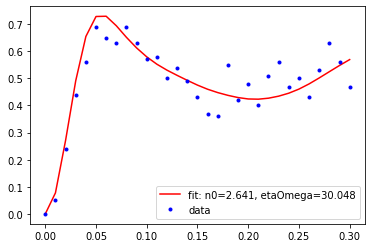

[ 2.64144068 30.04808283]


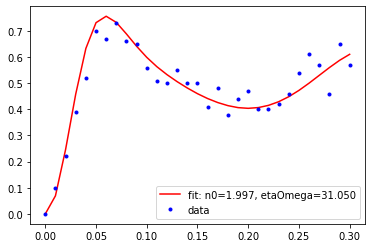

[ 1.99717208 31.05029157]


In [63]:
n350 = []
xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_002')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_003')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_004')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb[:16], BSB[:16], guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_005')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_006')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_007')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

xb, BSB = readFile('RamanTimeScan_CounterProp_BSB_Tilt_008')
guess = np.array([0.1, 45])
BSB_fit = FitBlue(xb, BSB, guess)
n350.append(BSB_fit[0])

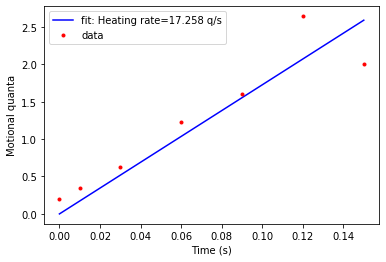

[17.25775145]


In [64]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
heatingFit(T, n350)

## Method 2: Least square fitting

In [65]:
import os

fnames = []
for root, dirs, files in os.walk("."):
    for filename in files:
        fnames.append(filename)
print(sorted(fnames))

['Error_001.log', 'Error_002.log', 'RamanTimeScan_CounterProp_BSB_Tilt_001', 'RamanTimeScan_CounterProp_BSB_Tilt_002', 'RamanTimeScan_CounterProp_BSB_Tilt_003', 'RamanTimeScan_CounterProp_BSB_Tilt_004', 'RamanTimeScan_CounterProp_BSB_Tilt_005', 'RamanTimeScan_CounterProp_BSB_Tilt_006', 'RamanTimeScan_CounterProp_BSB_Tilt_007', 'RamanTimeScan_CounterProp_BSB_Tilt_008', 'RamanTimeScan_CounterProp_BSB_Tilt_009', 'RamanTimeScan_CounterProp_BSB_Tilt_010', 'RamanTimeScan_CounterProp_BSB_Tilt_011', 'RamanTimeScan_CounterProp_BSB_Tilt_012', 'RamanTimeScan_CounterProp_BSB_Tilt_013', 'RamanTimeScan_CounterProp_BSB_Tilt_014', 'RamanTimeScan_CounterProp_BSB_Tilt_015', 'RamanTimeScan_CounterProp_BSB_Tilt_016', 'RamanTimeScan_CounterProp_BSB_Tilt_017', 'RamanTimeScan_CounterProp_BSB_Tilt_018', 'RamanTimeScan_CounterProp_BSB_Tilt_019', 'RamanTimeScan_CounterProp_BSB_Tilt_020', 'RamanTimeScan_CounterProp_BSB_Tilt_021', 'RamanTimeScan_CounterProp_BSB_Tilt_022', 'RamanTimeScan_CounterProp_BSB_Tilt_023',

In [74]:
BSB350 = sorted(fnames)[3:10]
BSB325 = sorted(fnames)[11:18]
BSB300 = sorted(fnames)[19:26]
BSB265 = sorted(fnames)[27:34]

# The noWait of BSB265 and 10 ms Wait is inversed
temp = BSB265[0]
BSB265[0] = BSB265[1]
BSB265[1] = temp

print(BSB350)
print(BSB325)
print(BSB300)
print(BSB265)

['RamanTimeScan_CounterProp_BSB_Tilt_002', 'RamanTimeScan_CounterProp_BSB_Tilt_003', 'RamanTimeScan_CounterProp_BSB_Tilt_004', 'RamanTimeScan_CounterProp_BSB_Tilt_005', 'RamanTimeScan_CounterProp_BSB_Tilt_006', 'RamanTimeScan_CounterProp_BSB_Tilt_007', 'RamanTimeScan_CounterProp_BSB_Tilt_008']
['RamanTimeScan_CounterProp_BSB_Tilt_010', 'RamanTimeScan_CounterProp_BSB_Tilt_011', 'RamanTimeScan_CounterProp_BSB_Tilt_012', 'RamanTimeScan_CounterProp_BSB_Tilt_013', 'RamanTimeScan_CounterProp_BSB_Tilt_014', 'RamanTimeScan_CounterProp_BSB_Tilt_015', 'RamanTimeScan_CounterProp_BSB_Tilt_016']
['RamanTimeScan_CounterProp_BSB_Tilt_018', 'RamanTimeScan_CounterProp_BSB_Tilt_019', 'RamanTimeScan_CounterProp_BSB_Tilt_020', 'RamanTimeScan_CounterProp_BSB_Tilt_021', 'RamanTimeScan_CounterProp_BSB_Tilt_022', 'RamanTimeScan_CounterProp_BSB_Tilt_023', 'RamanTimeScan_CounterProp_BSB_Tilt_024']
['RamanTimeScan_CounterProp_BSB_Tilt_027', 'RamanTimeScan_CounterProp_BSB_Tilt_026', 'RamanTimeScan_CounterProp_BSB

In [75]:
def LeastSquareFitting(x, ydata, fitdata):
    R = 0
    for i in range(len(x)):
        R += (ydata[i]-fitdata[i])**2
    return R

Test it

In [76]:
n0 = 5
Gamma = 0.1
etaOmega = etaOmega = 5*2*np.pi
H_red = H(n0, True, Gamma, etaOmega)
LeastSquareFitting(xr, RSB, H_red)

2.931436966936343

In [77]:
def ScanParameters(n0s, etaOmegas, xb, BSB):
    R_red = np.zeros((len(n0s), len(etaOmegas))) 
    R_blue = np.zeros((len(n0s), len(etaOmegas)))  
    Gamma = 0
    for i in range(len(n0s)):
        for j in range(len(etaOmegas)):
            #H_red = H(n0s[i], True, Gamma, etaOmegas[j])
            H_blue = H(n0s[i], False, Gamma, etaOmegas[j], times = xb)
            #R_red[i][j] = LeastSquareFitting(x, RSB, H_red)
            R_blue[i][j] = LeastSquareFitting(xb, BSB, H_blue)
    #return R_red, R_blue
    return R_blue

## Write the cell above as a function

In [99]:
# Caution: The time cost will be long if the range of scanning is too large

def lSFit(filenames, n0s, etaOmegas):
    # filenames contains the files with different waiting time for one RF setting
    # n0s is the scanning range for motional quanta
    # etaOmegas is the scanning range for eta*Omega
    # waitTime is an array contains corresponding waitTime
    
    
    
    now1 = datetime.datetime.now()

    n = []
    for i in range(len(filenames)):
        xb, BSB = readFile(filenames[i])
        R_blue = ScanParameters(n0s, etaOmegas, xb[:16], BSB[:16])
        plt.imshow(R_blue)
        plt.show()

        row, col = np.where(R_blue == R_blue.min())
        n0 = n0s[row][0]
        etaOmega = etaOmegas[col][0]
        print(n0)
        print(etaOmega)

        ax2 = plt.subplot(111)
        ax2.plot(xb, H(n0, False, 0, etaOmega, xb), label = "BSB Rabi Oscillation")
        ax2.plot(xb, BSB, 'b.')
        ax2.set_xlabel("Time")
        ax2.set_ylabel("$P_e$")
        ax2.legend(loc = "upper right")
        plt.show()


        n.append(n0)
    now2 = datetime.datetime.now()
    print(now2-now1)

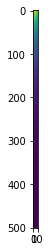

2.33622
27.0


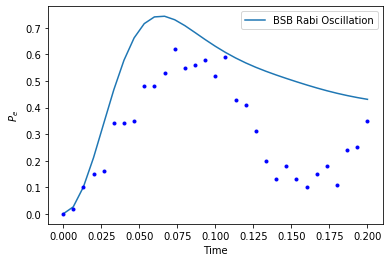

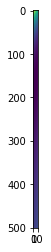

0.91896
26.4


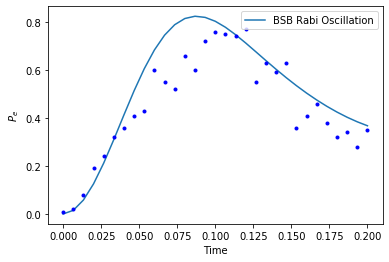

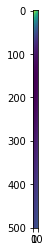

1.17012
25.0


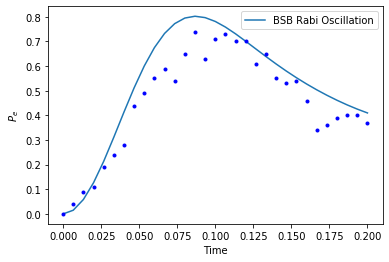

0:04:39.502264


In [83]:
n0s = np.linspace(0.01, 3, 501)
etaOmegas = np.linspace(25, 27, 11)
waitTime = [0.0, 0.01, 0.03, 0.06, 0.09]

lSFit(BSB265[:3], n0s, etaOmegas)

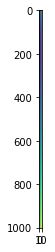

1.744
25.0


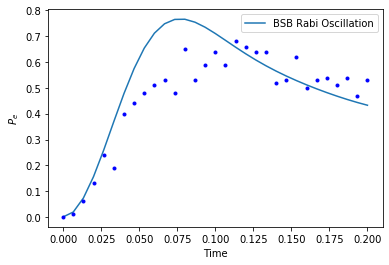

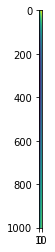

2.34
25.0


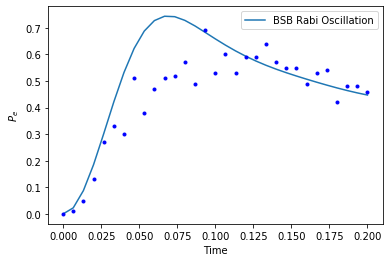

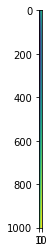

1.704
25.0


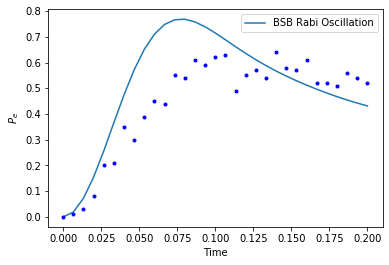

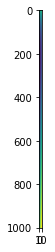

2.02
25.0


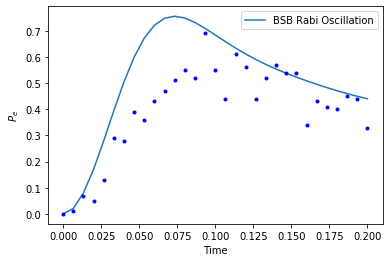

0:13:02.704527


In [85]:
n0s = np.linspace(1, 5, 1001)
etaOmegas = np.linspace(25, 27, 11)

lSFit(BSB265[3:], n0s, etaOmegas)

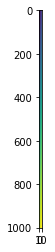

1.0
26.0


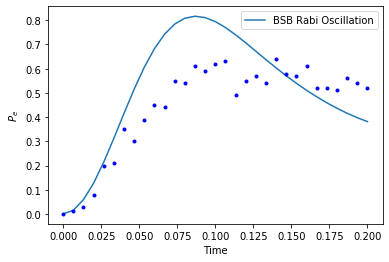

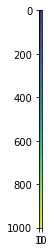

1.0
26.0


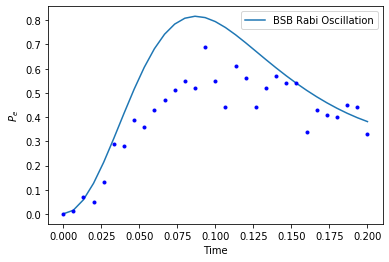

0:04:47.334168


In [100]:
n0s = np.linspace(1, 5, 1001)
etaOmegas = np.linspace(26, 27, 11)

lSFit(BSB265[5:], n0s, etaOmegas)

## RF = 300

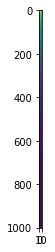

0.77527
36.5


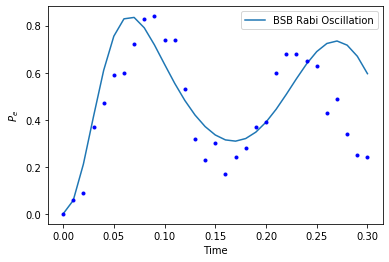

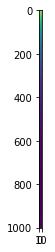

0.78517
36.5


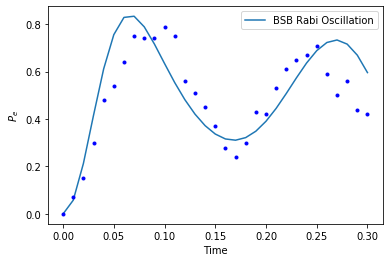

0:07:08.012235


In [94]:
n0s = np.linspace(0.01, 1, 1001)
etaOmegas = np.linspace(35.5, 36.5, 11)

lSFit(BSB300[:2], n0s, etaOmegas)

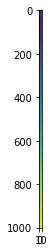

1.148
35.5


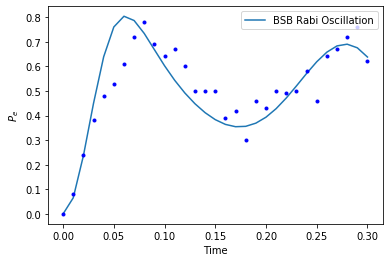

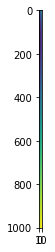

1.524
35.5


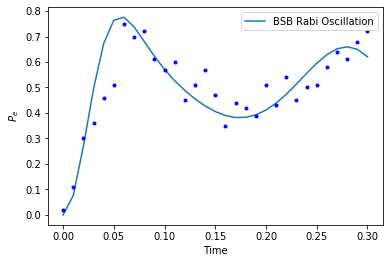

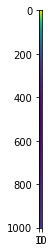

3.072
35.5


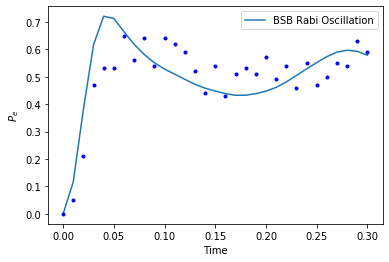

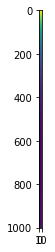

3.816
35.5


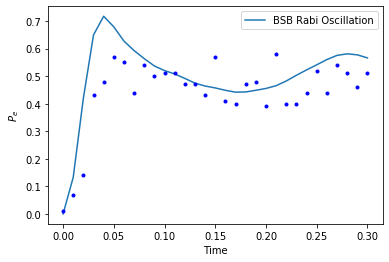

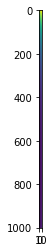

3.848
35.5


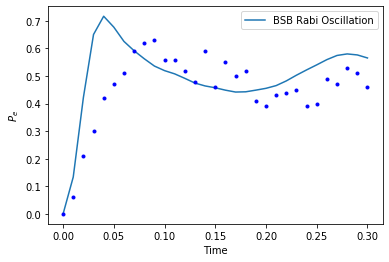

0:23:34.499540


In [95]:
n0s = np.linspace(1, 5, 1001)
etaOmegas = np.linspace(35.5, 36.5, 11)

lSFit(BSB300[2:], n0s, etaOmegas)

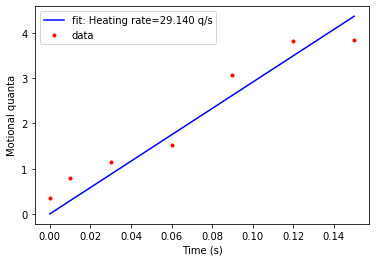

[29.139752]


In [97]:
T = [0, 0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
n300 = [0.355, 0.78517, 1.148, 1.524, 3.072, 3.816, 3.848]
heatingFit(T, n300)